In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
from scipy import stats
import seaborn as sns

# Scrape Data

In [2]:
#set years you want

YearStart = 2010
YearEnd = 2020

In [3]:
TBigDF = pd.DataFrame()
for i in range((YearStart - 1), (YearEnd + 1)):
    tempurl1 = "https://www.pro-football-reference.com/years/"
    tempurl2 = "/receiving.htm"
    tempurl3 = str(i)
    tempurlF = tempurl1 + tempurl3 + tempurl2
    page = requests.get(tempurlF)
    soup = BeautifulSoup(page.text, 'html.parser')
    table = soup.find_all('table')
    df = pd.read_html(str(table))[0]
    df['Year'] = i
    TBigDF = TBigDF.append(df)

# Wrangle data

In [4]:
#here we make a copy of the df and were going to use that so we dont have to scrape again any time we change things
BigDF = TBigDF.copy()

In [5]:
BigDF = BigDF.loc[(BigDF['Pos'] == "WR") | (BigDF['Pos'] == "wr") | (BigDF['Pos'].isnull())]
BigDF['Player'].replace('\*\+', '',inplace = True, regex = True)
BigDF['Player'].replace('\+', '',inplace = True, regex = True)
BigDF['Player'].replace('\*', '',inplace = True, regex = True)
BigDF['Player'] = BigDF['Player'].str.strip()
BigDF['Yds'] = BigDF['Yds'].astype(int)
BigDF.reset_index(inplace = True)

In [6]:
BigDF = BigDF.sort_values(['Player', 'Age'])

In [7]:
RnSDF = BigDF.groupby('Player').head(2)

In [8]:
temp = RnSDF['Player'].value_counts()
RnSDF = RnSDF[RnSDF['Player'].isin(temp[temp>1].index)]

In [9]:
RnSDF['FantasyPoints'] = (RnSDF['Yds'].astype(int) * .1) + (RnSDF['TD'].astype(int) * 6)

In [10]:
RookieDF = RnSDF.drop_duplicates(subset='Player', keep='first')

In [11]:
RookieDF = RookieDF.loc[RookieDF['Year']> (YearStart - 1)]

In [12]:
#set the threshold to whatever you want between -3 and 3. the bigger the number, the more elite the rookie seasons you will be looking at
threshold = 1.5
RookieDF = RookieDF[(stats.zscore(RookieDF.Yds) > threshold)]

In [13]:
SophDF = RnSDF.drop_duplicates(subset='Player', keep='last')

In [14]:
RnSDF = pd.merge(RookieDF, SophDF, how="inner", on='Player')

In [15]:
RnSDF = RnSDF.loc[RnSDF['GS_y'].astype(int)>10]

In [16]:
RnSDF['Growth'] = RnSDF['Yds_y'] - RnSDF['Yds_x']

In [22]:
RnSDF['PercentGrowth'] = ((RnSDF['Yds_y'] - RnSDF['Yds_x']) / RnSDF['Yds_x'])*100

# Analyze data

In [18]:
RnSDF.Growth.mean()

216.47619047619048

beta =  0.4178796286726736  ,  intercept =  686.3582102080719


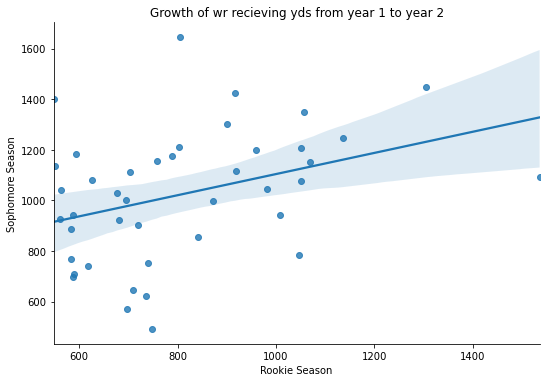

In [19]:
#regress year 2 on to year 1
sns.lmplot(x='Yds_x',y='Yds_y', data=RnSDF,fit_reg=True, aspect=1.5)
plt.xlabel("Rookie Season")
plt.ylabel("Sophomore Season")
plt.title("Growth of wr recieving yds from year 1 to year 2")

slope, intercept, r_value, pv, se = stats.linregress(RnSDF.Yds_x.values,RnSDF.Yds_y.values)
print('beta = ', slope,' , ', 'intercept = ', intercept)


beta =  -0.5821203713273265  ,  intercept =  686.358210208072


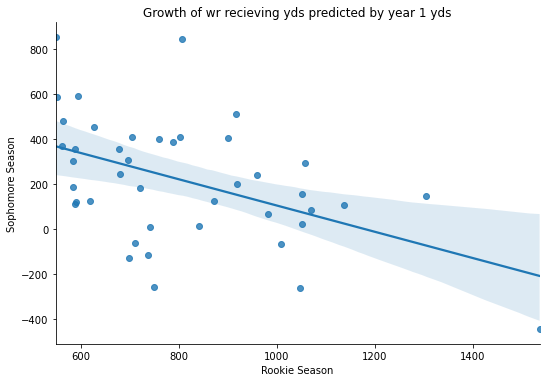

In [20]:
# regress growth onto year 1
sns.lmplot(x='Yds_x',y='Growth', data=RnSDF,fit_reg=True, aspect=1.5)
plt.xlabel("Rookie Season")
plt.ylabel("Sophomore Season")
plt.title("Growth of wr recieving yds predicted by year 1 yds")

slope, intercept, r_value, pv, se = stats.linregress(RnSDF.Yds_x.values, RnSDF.Growth.values)
print('beta = ', slope,' , ', 'intercept = ', intercept)

beta =  -0.09510382288623812  ,  intercept =  109.31124437713345


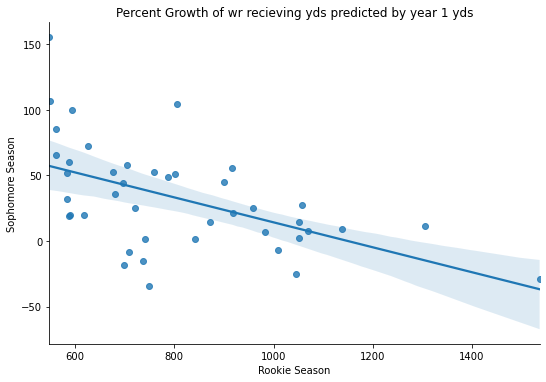

In [23]:
#regress growth as percentage onto year 1
sns.lmplot(x='Yds_x',y='PercentGrowth', data=RnSDF,fit_reg=True, aspect=1.5)
plt.xlabel("Rookie Season")
plt.ylabel("Sophomore Season")
plt.title("Percent Growth of wr recieving yds predicted by year 1 yds")

slope, intercept, r_value, pv, se = stats.linregress(RnSDF.Yds_x.values, RnSDF.PercentGrowth.values)
print('beta = ', slope,' , ', 'intercept = ', intercept)

beta =  0.41445050337679895  ,  intercept =  94.57034984977835


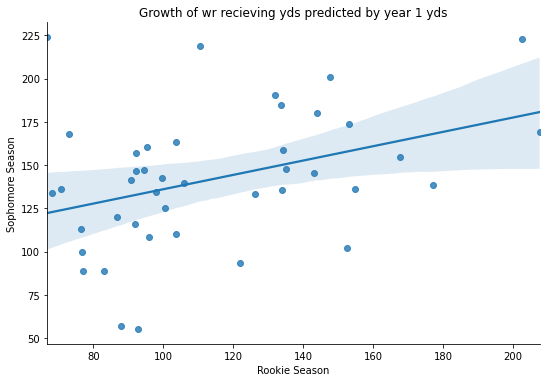

In [27]:
#regress growth of fantasy points year 2 onto year 1
sns.lmplot(x='FantasyPoints_x',y='FantasyPoints_y', data=RnSDF,fit_reg=True, aspect=1.5)
plt.xlabel("Rookie Season")
plt.ylabel("Sophomore Season")
plt.title("Growth of wr recieving yds predicted by year 1 yds")

slope, intercept, r_value, pv, se = stats.linregress(RnSDF.FantasyPoints_x.values,RnSDF.FantasyPoints_y.values)
print('beta = ', slope,' , ', 'intercept = ', intercept)